In [3]:
# Add directory above current directory to path
import sys; 
if not ".." in sys.path:
    sys.path.insert(0, '..')
    
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from regularity_analysis.feature_extraction import sliding_window_calculation, stat_evolution_calculation, multiscale_entropy

from utils.data_utils import *
from utils.time_utils import *
%load_ext autoreload
%autoreload 2

#run this cell for fullscreen jupyter cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def prepare_result(customer_data, result_data):
    """
    Concatenate customer base frame with entropy result frame for quick Seaborn plot building
    """
    dfs = [customer_data, result_data]
    
    if type(result_data) == list:
        dfs = [customer_data] + result_data
    
    return pd.concat(dfs, axis=1)

In [6]:
#set up data and result paths
customer_base_path = "../DATA_GYM/sanitized_customer_base.csv"
login_data_path = "../DATA_GYM/sanitized_login_data.csv"
result_folder = "../results/regularity/statistics/2020-04-20/"
file_ext = ".csv"
result_names = ["binary_regularity_results", "binary_fourier_results", "td_regularity_results", "td_fourier_results", "normalized_spectral_entropy_results"]

In [7]:
login_data = load_login_data(login_data_path)
customer_data = load_customer_data(customer_base_path)
#sorting by date avoids surprises when calling the timedelta method
customer_data.sort_values(by=["CUST_CODE", "DATE_SAVED"], inplace=True)

In [8]:
result_dfs = []

for name in result_names:
    stats = load_result_data(result_folder + name + file_ext)
    result_dfs.append(stats) 

In [9]:
regularity_result = prepare_result(customer_data, result_dfs)
regularity_result.describe()

,NUM_VISITS,Binary_ApEn_m=2_r=0.2,Binary_ApEn_m=3_r=0.2,Binary_ApEn_m=4_r=0.2,Binary_SampEn_m=2_r=0.2,Binary_SampEn_m=3_r=0.2,Binary_SampEn_m=4_r=0.2,Binary_IntRepEn_n=3_lag=1,Binary_IntRepEn_n=5_lag=1,Binary_IntRepEn_n=7_lag=1,...,WSEN_boxcar_128,WSEN_boxcar_256,TD_WSEN_hann_128,TD_WSEN_hann_256,TD_WSEN_parzen_128,TD_WSEN_parzen_256,TD_WSEN_bartlett_128,TD_WSEN_bartlett_256,TD_WSEN_boxcar_128,TD_WSEN_boxcar_256
count,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,138563.000000,...,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000,133425.000000
mean,63.952253,0.335708,0.320719,0.303833,0.230971,0.214750,0.200470,0.352241,0.336255,0.317791,...,0.778855,0.767854,0.959236,0.959236,0.959236,0.959236,0.959236,0.959236,0.959236,0.959236
std,99.670243,0.275043,0.266339,0.255421,0.244063,0.235935,0.228851,0.283015,0.273127,0.259554,...,0.331976,0.327479,0.178216,0.178216,0.178216,0.178216,0.178216,0.178216,0.178216,0.178216
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.085650,0.077177,0.070299,0.037208,0.032864,0.029142,0.094631,0.087708,0.080060,...,0.861720,0.853648,0.989834,0.989834,0.989834,0.989834,0.989834,0.989834,0.989834,0.989834
50%,28.000000,0.296462,0.279929,0.261842,0.147239,0.129407,0.115507,0.314626,0.297778,0.280295,...,0.915781,0.901878,0.994662,0.994662,0.994662,0.994662,0.994662,0.994662,0.994662,0.994662
75%,74.000000,0.545153,0.522487,0.495910,0.352048,0.320483,0.293128,0.567964,0.545099,0.517672,...,0.950722,0.932033,0.997882,0.997882,0.997882,0.997882,0.997882,0.997882,0.997882,0.997882
max,2089.000000,0.998034,0.993673,0.986375,1.343954,1.621488,2.115477,0.998427,0.993053,0.986180,...,0.996060,0.998352,0.999728,0.999728,0.999728,0.999728,0.999728,0.999728,0.999728,0.999728


In [7]:
#convert the timedelta columns to floats
regularity_result["CONTRACT_DURATION"] = regularity_result.apply(lambda x: x.CONTRACT_DURATION / pd.Timedelta(days=1), axis=1)
regularity_result["ACTIVE_DURATION"] = regularity_result.apply(lambda x: x.ACTIVE_DURATION / pd.Timedelta(days=1), axis=1)
regularity_result["VISITS_PER_DAY"] = regularity_result.apply(lambda x: x.NUM_VISITS / x.CONTRACT_DURATION, axis=1)

# Checking users with extreme values 

In [8]:
#Time series plot function
def bin_series_plot(cust_code, lags=None, dpi=220, style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    global login_data, customer_data
    
    customer_logins = login_data[login_data["CUST_CODE"] == cust_code]
    customer = customer_data.loc[cust_code]

    bin_series = construct_binary_visit_series(customer, customer_logins, login_data["DATE_SAVED"].max())

    with plt.style.context(style):    
        plt.figure(figsize=(3840/dpi, 2160/dpi), dpi=dpi)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        bin_series.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(bin_series)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.4f}'.format(p_value))
        smt.graphics.plot_acf(bin_series, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(bin_series, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [9]:
#Timedelta series plot function
def td_series_plot(cust_code, lags=None, dpi=220, style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    global login_data, customer_data
    
    customer_logins = login_data[login_data["CUST_CODE"] == cust_code]
    customer = customer_data.loc[cust_code]
    td_series = get_timedeltas(customer_logins["DATE_SAVED"])
    
    with plt.style.context(style):    
        plt.figure(figsize=(3840/dpi, 2160/dpi), dpi=dpi)
        layout = (2, 2)
        td_ax1 = plt.subplot2grid(layout, (0, 0))
        td_ax2 = plt.subplot2grid(layout, (0, 1))
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        small_tds = td_series[td_series < 50]
        large_tds = td_series[td_series > 50]
        small_tds.hist(ax=td_ax1, bins=50)
        large_tds.hist(ax=td_ax2, bins=50)
        p_value = sm.tsa.stattools.adfuller(td_series)[1]
        td_ax1.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.4f}'.format(p_value))
        smt.graphics.plot_acf(td_series, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(td_series, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [10]:
def bin_td_summaryplot(cust_code, dpi=220, style="bmh"):
    """
    Summary data plot for a customer 
    """
    global login_data, customer_data
    
    customer_logins = login_data[login_data["CUST_CODE"] == cust_code]
    customer = customer_data.loc[cust_code]
    bin_series = construct_binary_visit_series(customer, customer_logins, login_data["DATE_SAVED"].max())
    td_series = get_timedeltas(customer_logins["DATE_SAVED"])
    
    bin_periodogram = get_periodogram(bin_series)
    bin_welch = get_welch_periodogram(bin_series)
    td_periodogram = get_periodogram(td_series)
    td_welch = get_welch_periodogram(td_series)
    
    with plt.style.context(style):    
        plt.figure(figsize=(3840/dpi, 2160/dpi), dpi=dpi)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        td_ax = plt.subplot2grid(layout, (0, 1))
        tsf_ax = plt.subplot2grid(layout, (1, 0))
        tdf_ax = plt.subplot2grid(layout, (1, 1))

        bin_series.plot(ax=ts_ax)
        td_series.hist(ax=td_ax, bins=100)
        bin_periodogram.plot(ax=tsf_ax, label="Binary Periodogram")
        bin_welch.plot(ax=tsf_ax, label="Binary Welch Periodogram")
        td_periodogram.plot(ax=tdf_ax, label="TD Periodogram")
        td_welch.plot(ax=tdf_ax, label="TD Welch Periodogram")
        tsf_ax.legend()
        tdf_ax.legend()
        
        ts_ax.set_title("Percentage of days visited: {0:.2f} %".format(100 * bin_series.sum() / len(bin_series.index)))
        plt.tight_layout()

In [11]:
def rolling_userplot(cust_code, window_size=30, dpi=220, style="bmh", stat_name="ApEn"):
    """
    Summary data plot for a customer 
    """
    global login_data, customer_data
    
    customer_logins = login_data[login_data["CUST_CODE"] == cust_code]
    customer = customer_data.loc[cust_code]
    bin_series = construct_binary_visit_series(customer, customer_logins, login_data["DATE_SAVED"].max())
    bin_welch = get_welch_periodogram(bin_series)
    
    rolling_stat = sliding_window_calculation(bin_series, stat_name=stat_name, window_size=window_size)
    
    with plt.style.context(style):    
        plt.figure(figsize=(3840/dpi, 2160/dpi), dpi=dpi)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        entropy_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        
        bin_series.plot(ax=ts_ax)
        rolling_stat.plot(ax=entropy_ax)
        
        ts_ax.set_title("Percentage of days visited: {0:.2f} %".format(100 * bin_series.sum() / len(bin_series.index)))
        plt.tight_layout()

In [12]:
def cumulative_userplot(cust_code, dpi=220, style="bmh", stat_name="ApEn"):
    """
    Summary data plot for a customer 
    """
    global login_data, customer_data
    
    customer_logins = login_data[login_data["CUST_CODE"] == cust_code]
    customer = customer_data.loc[cust_code]
    bin_series = construct_binary_visit_series(customer, customer_logins, login_data["DATE_SAVED"].max())
    bin_welch = get_welch_periodogram(bin_series)
    #cumulative_stat(bin_series, stat_name=stat_name)
    
    cumulative_stats = stat_evolution_calculation(bin_series, stat_name=stat_name)
    
    with plt.style.context(style):   
        #4K 220 dpi
        plt.figure(figsize=(3840/dpi, 2160/dpi), dpi=dpi)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        entropy_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        
        bin_series.plot(ax=ts_ax)
        cumulative_stats.plot(ax=entropy_ax)
        
        ts_ax.set_title("Percentage of days visited: {0:.2f} %".format(100 * bin_series.sum() / len(bin_series.index)))
        plt.tight_layout()

In [1]:
stat_name = "WSEN_boxcar_128"
n = 50000
sample = regularity_result.nsmallest(n, stat_name).sample(1)
sample_code = sample.index[0]
print(sample[stat_name])
print(sample_code)

NameError: name 'regularity_result' is not defined

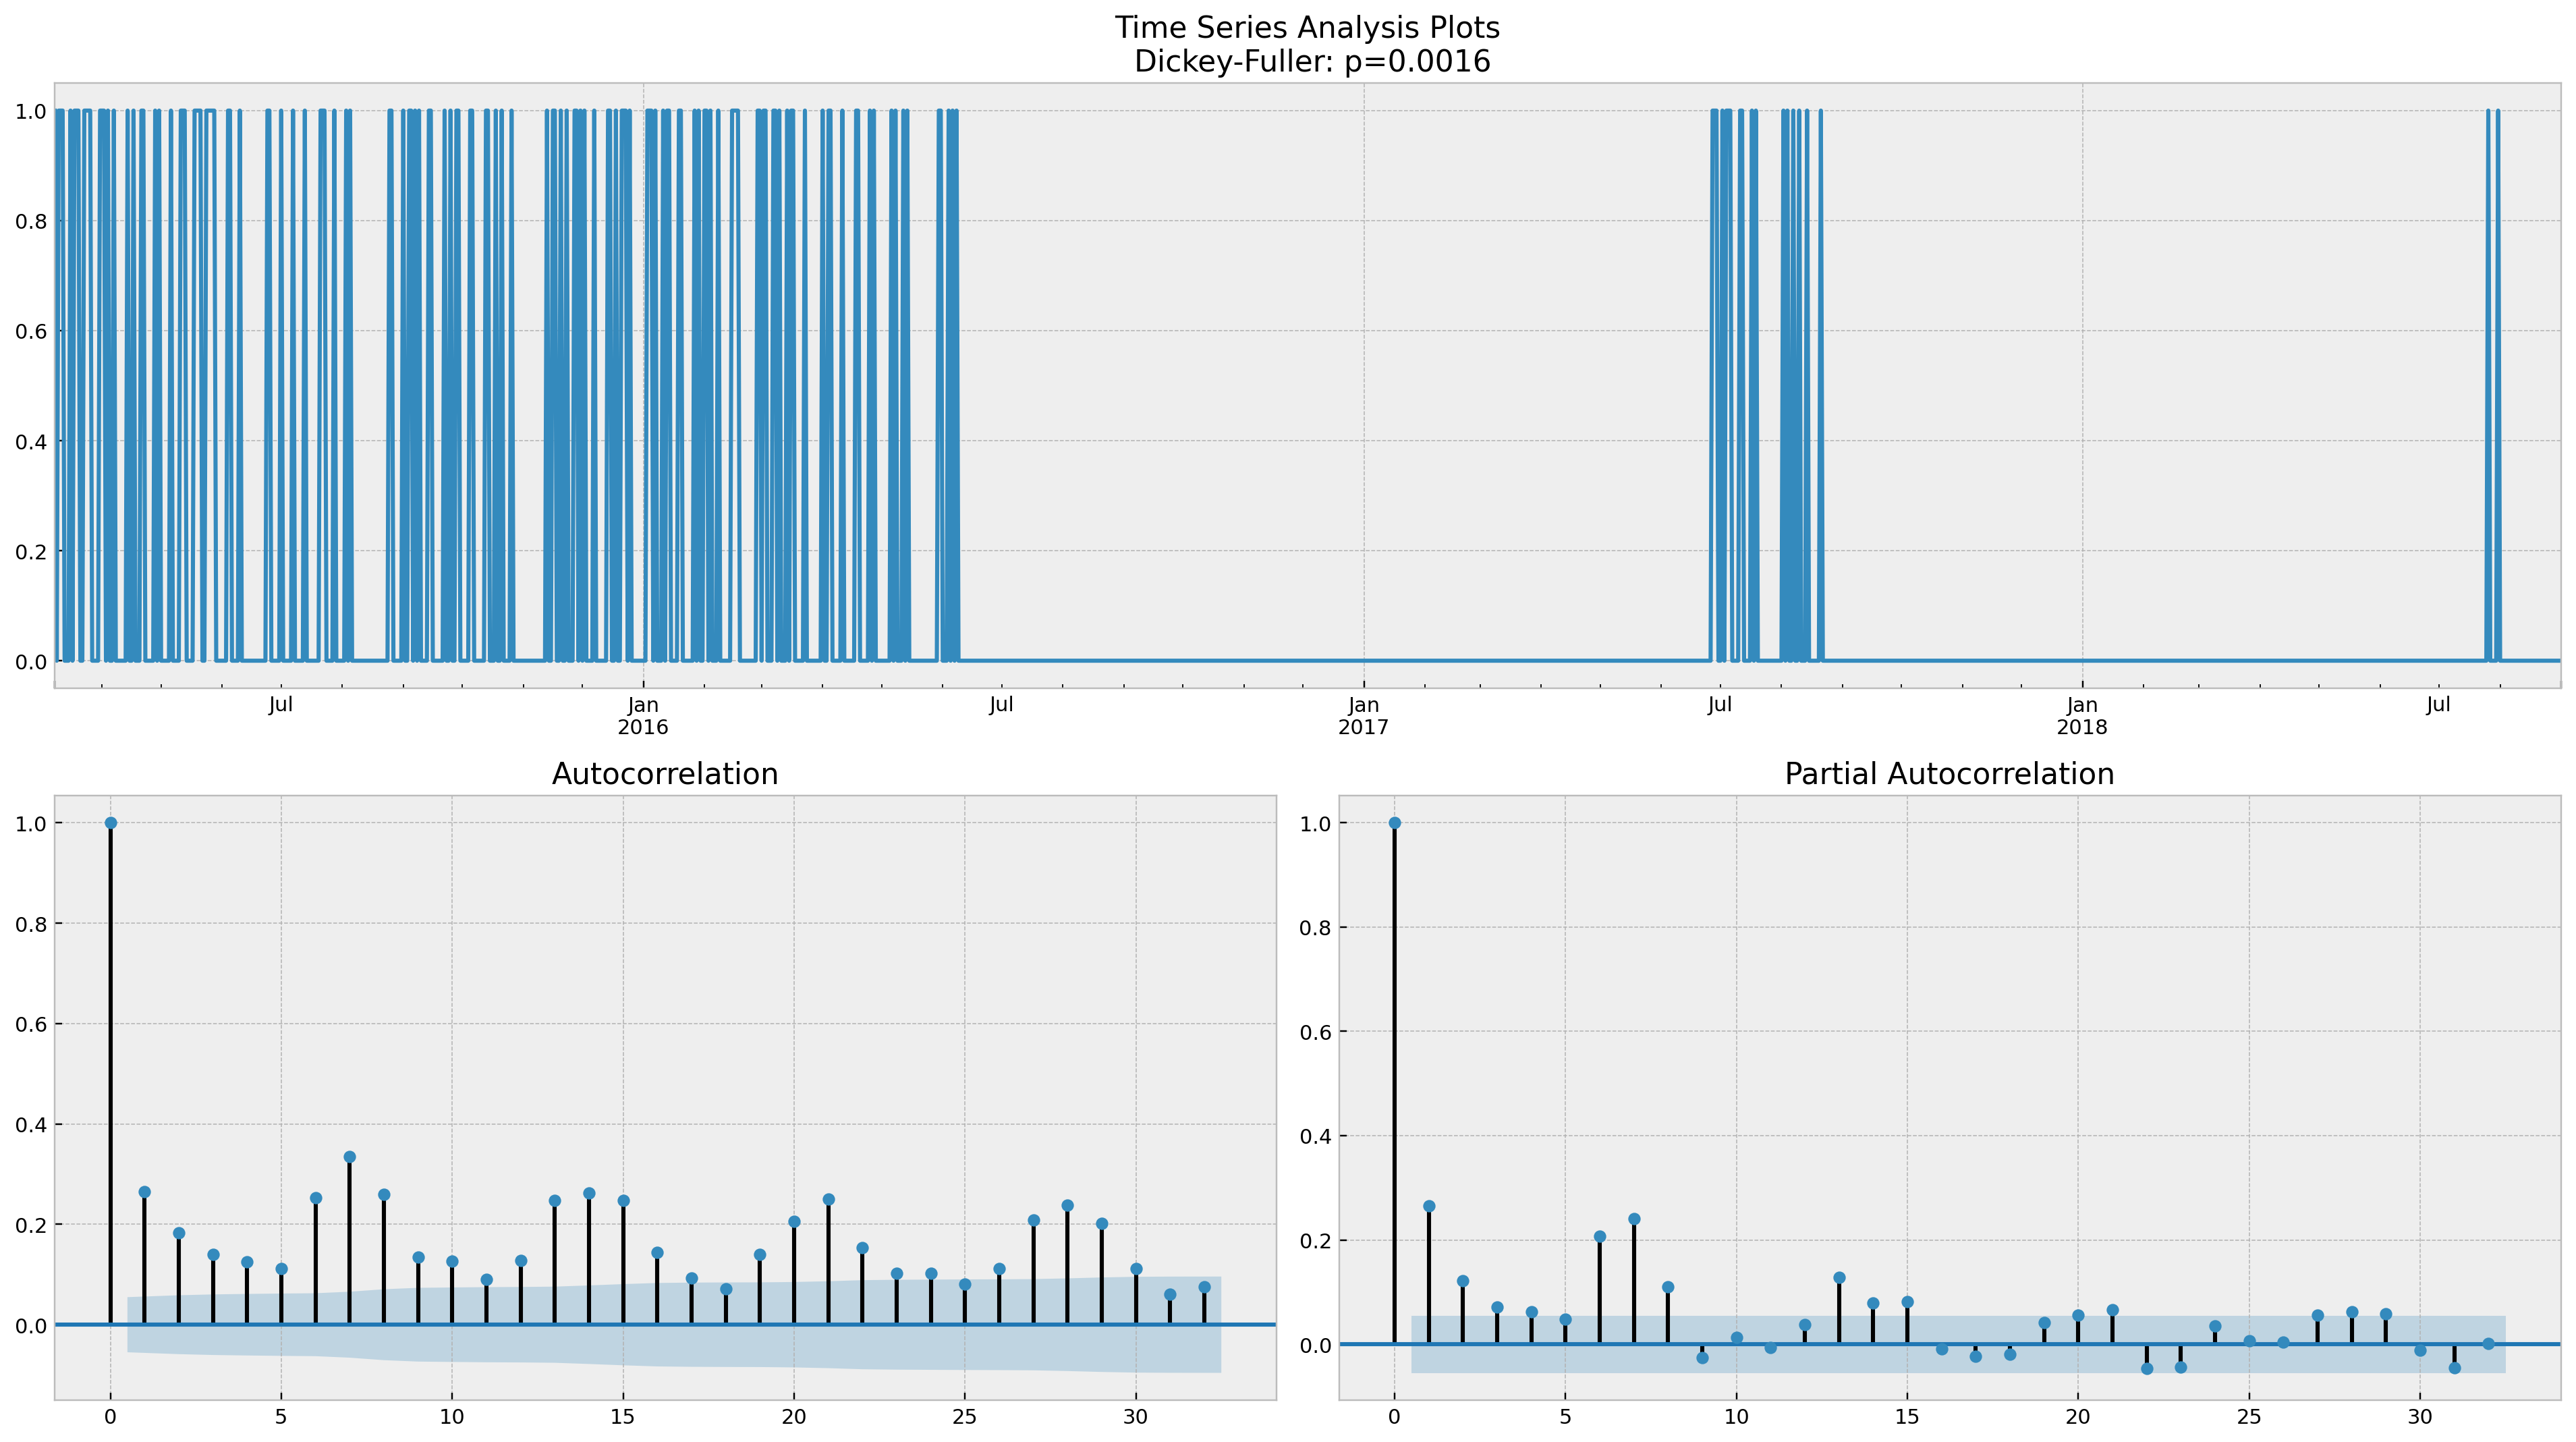

In [14]:
bin_series_plot(sample_code)

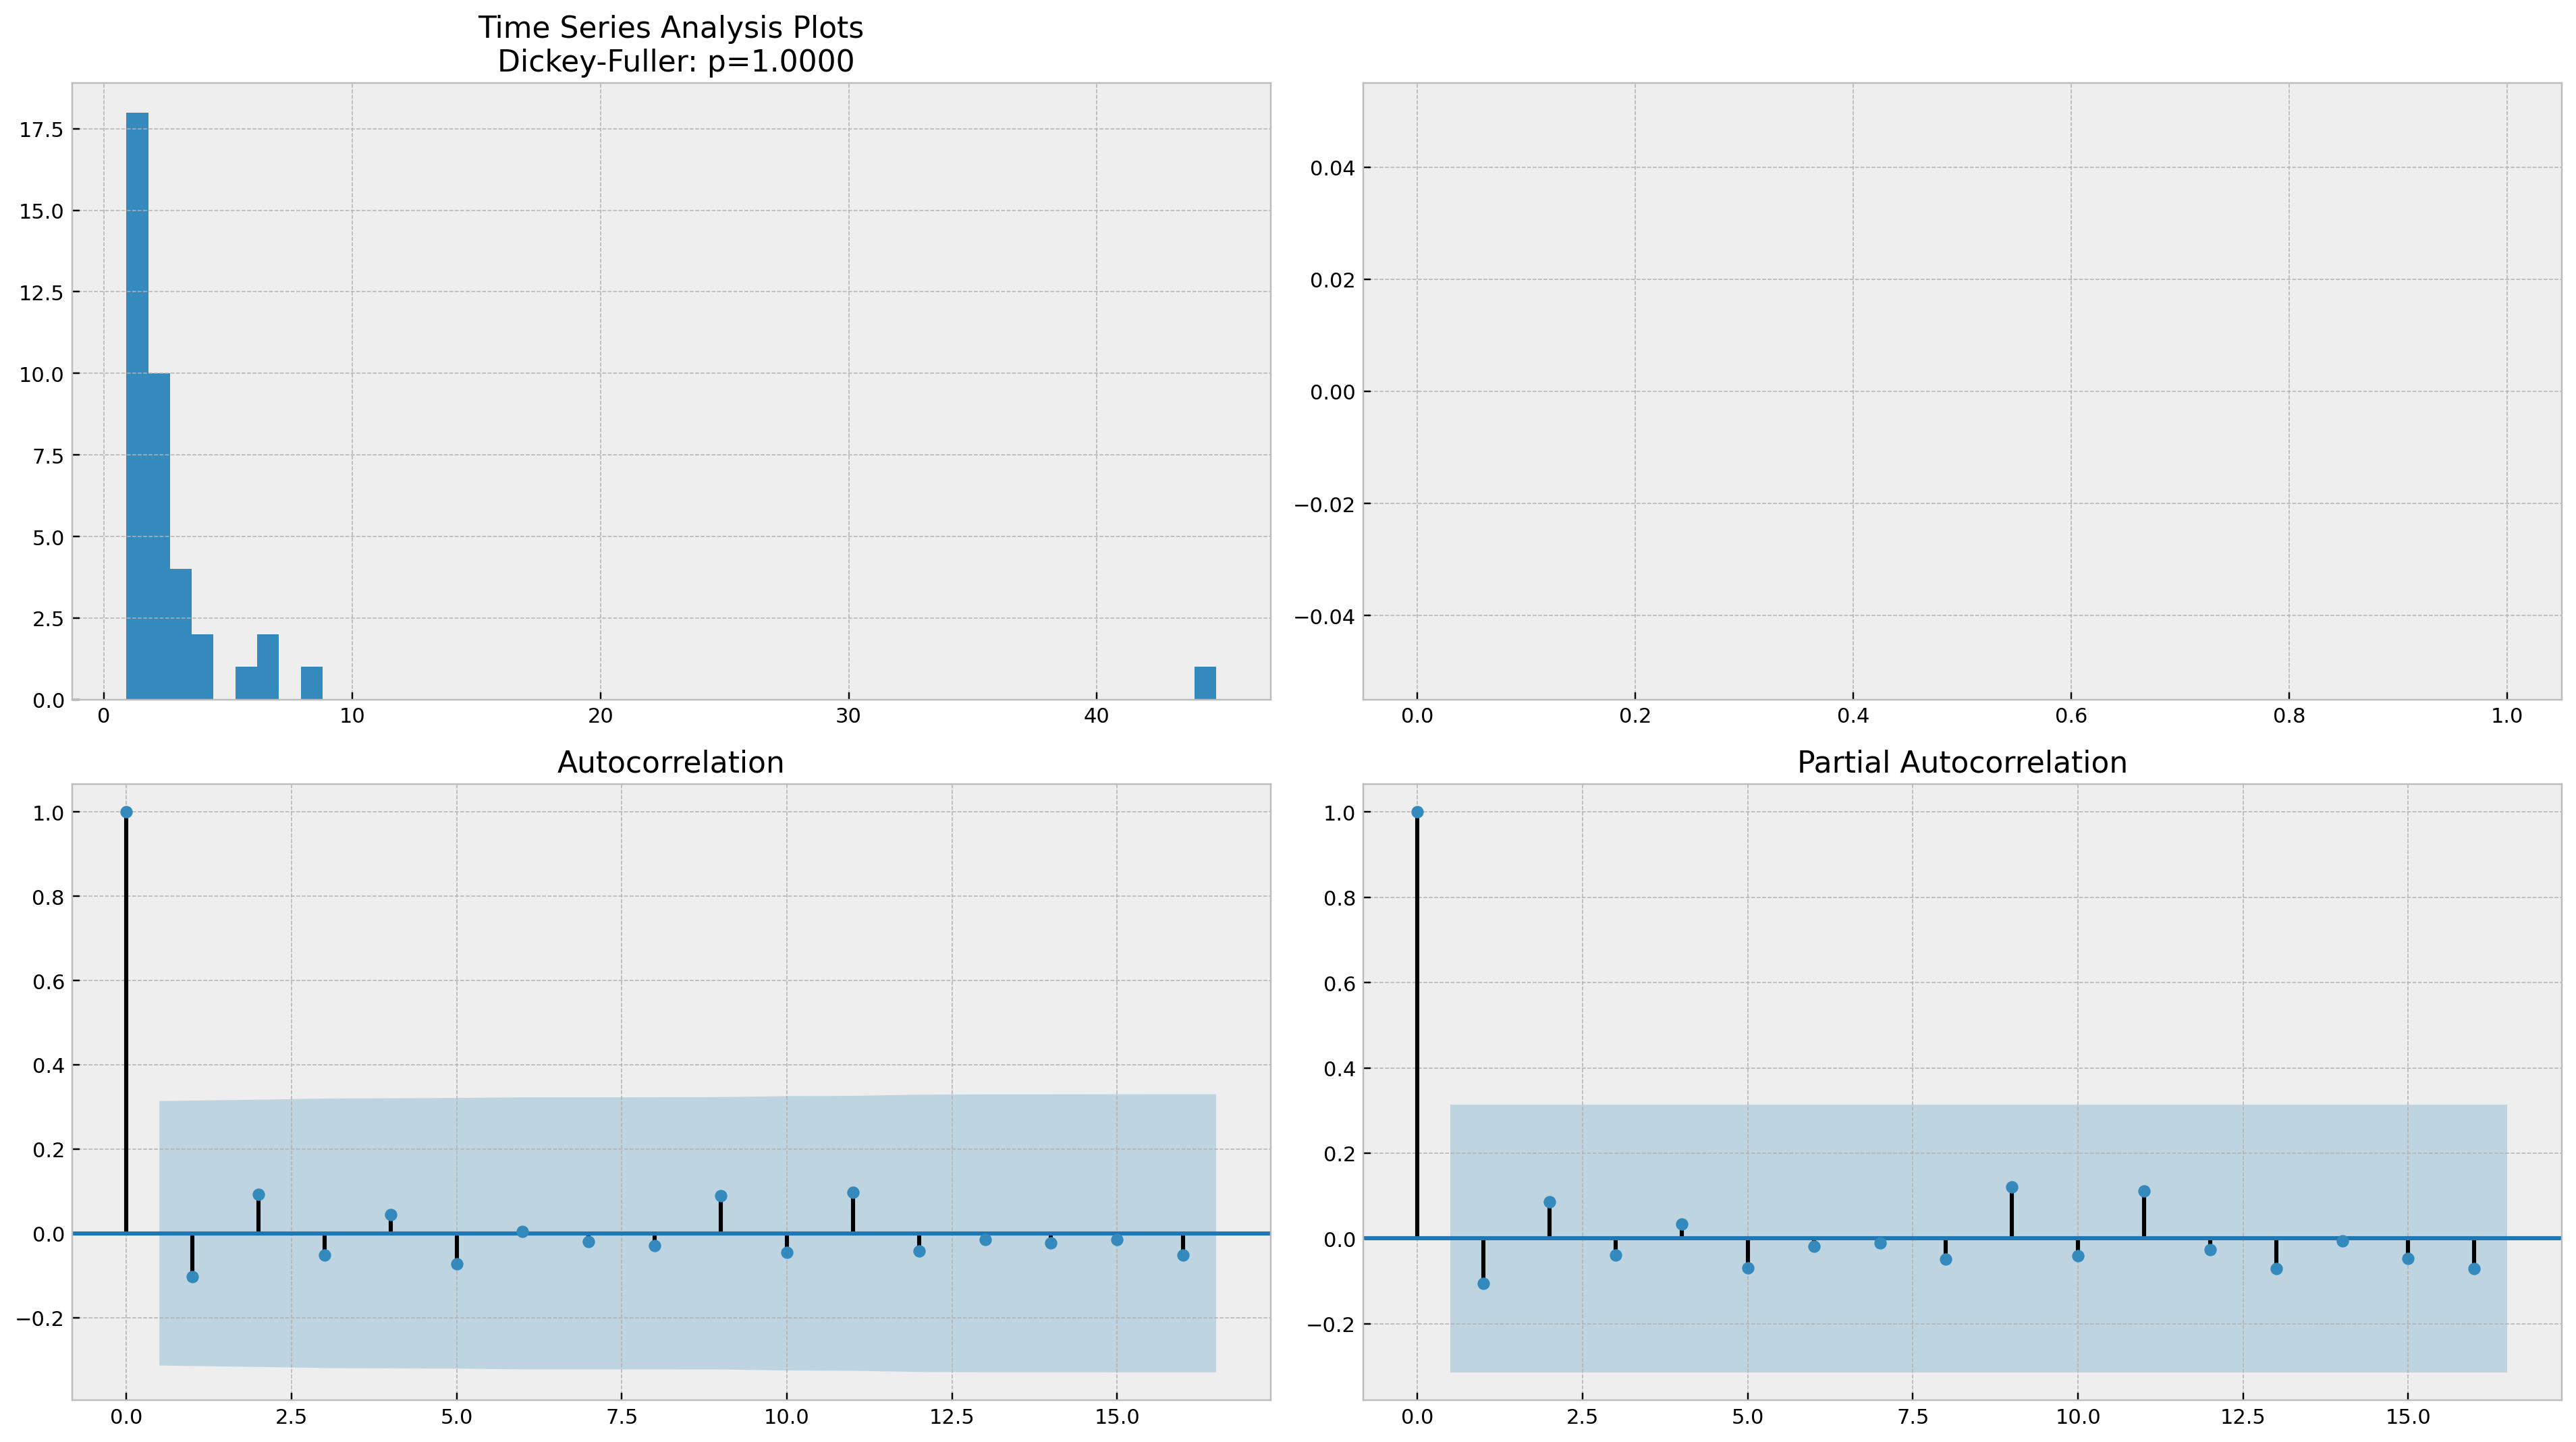

In [258]:
td_series_plot(sample_code)

/Users/nicholasjunge/.local/share/virtualenvs/codebase-s-6Wzjjx/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 128 is greater than input length  = 39, using nperseg = 39
  warnings.warn('nperseg = {0:d} is greater than input length '


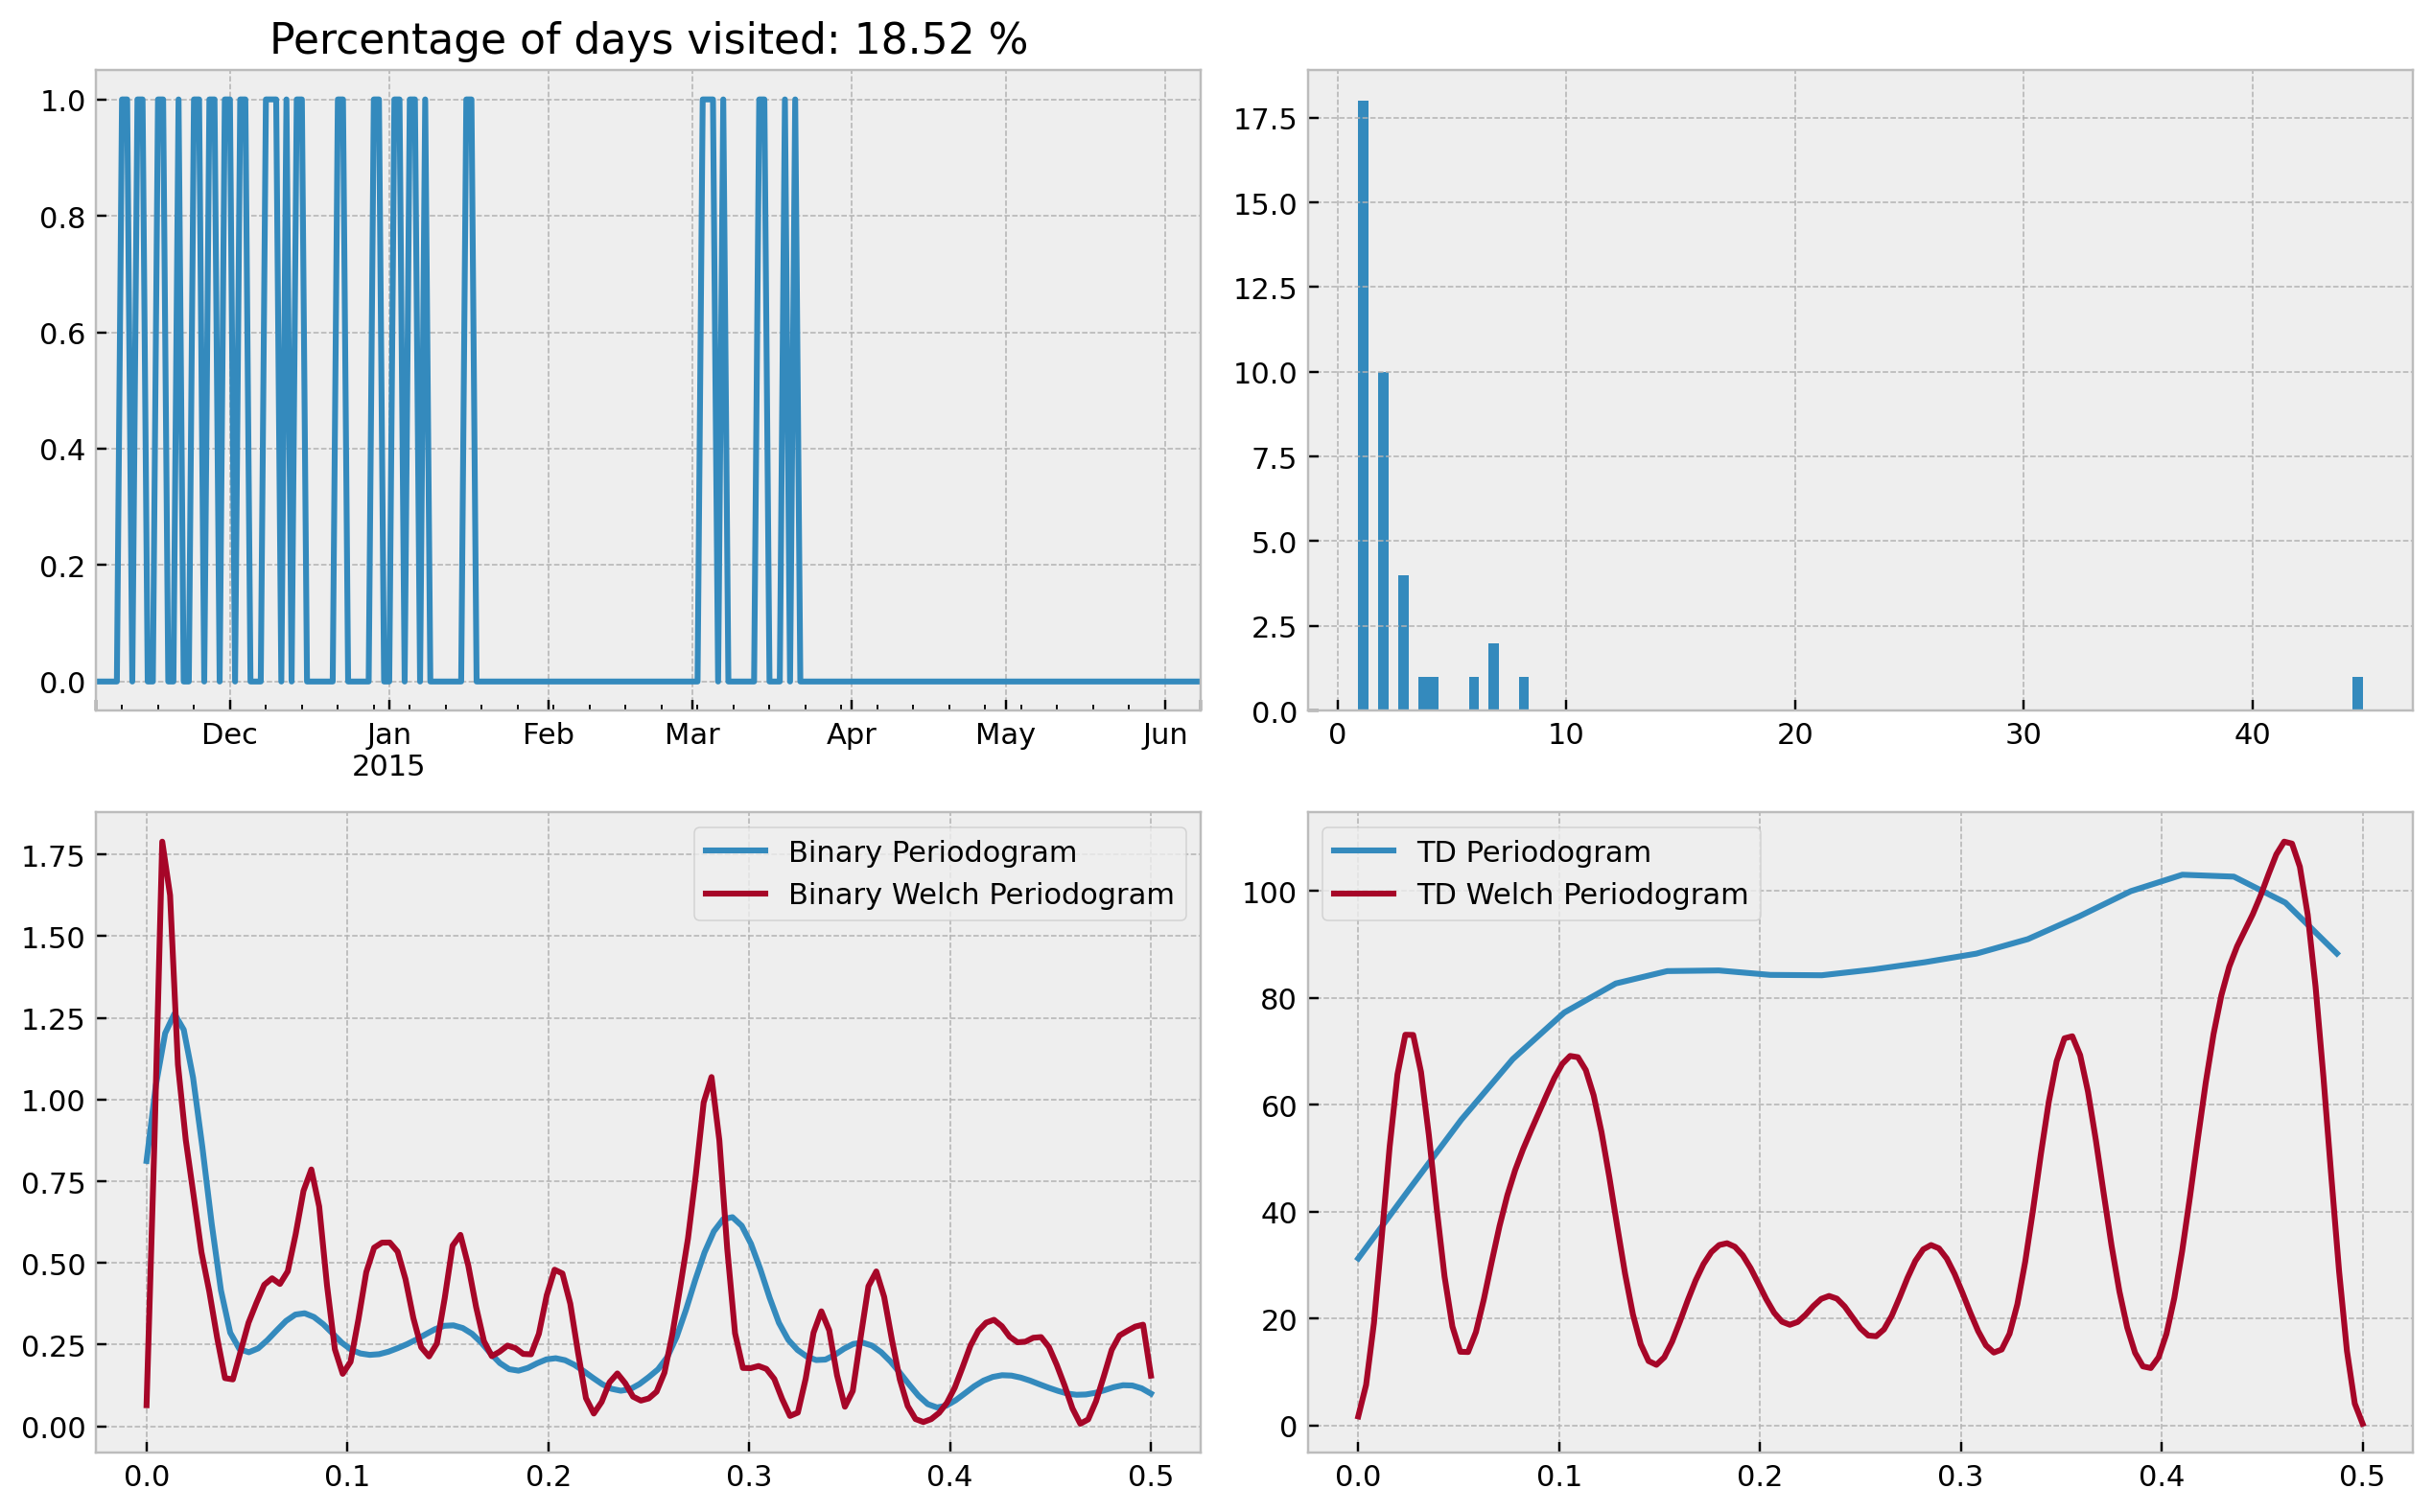

In [259]:
bin_td_summaryplot(sample_code)

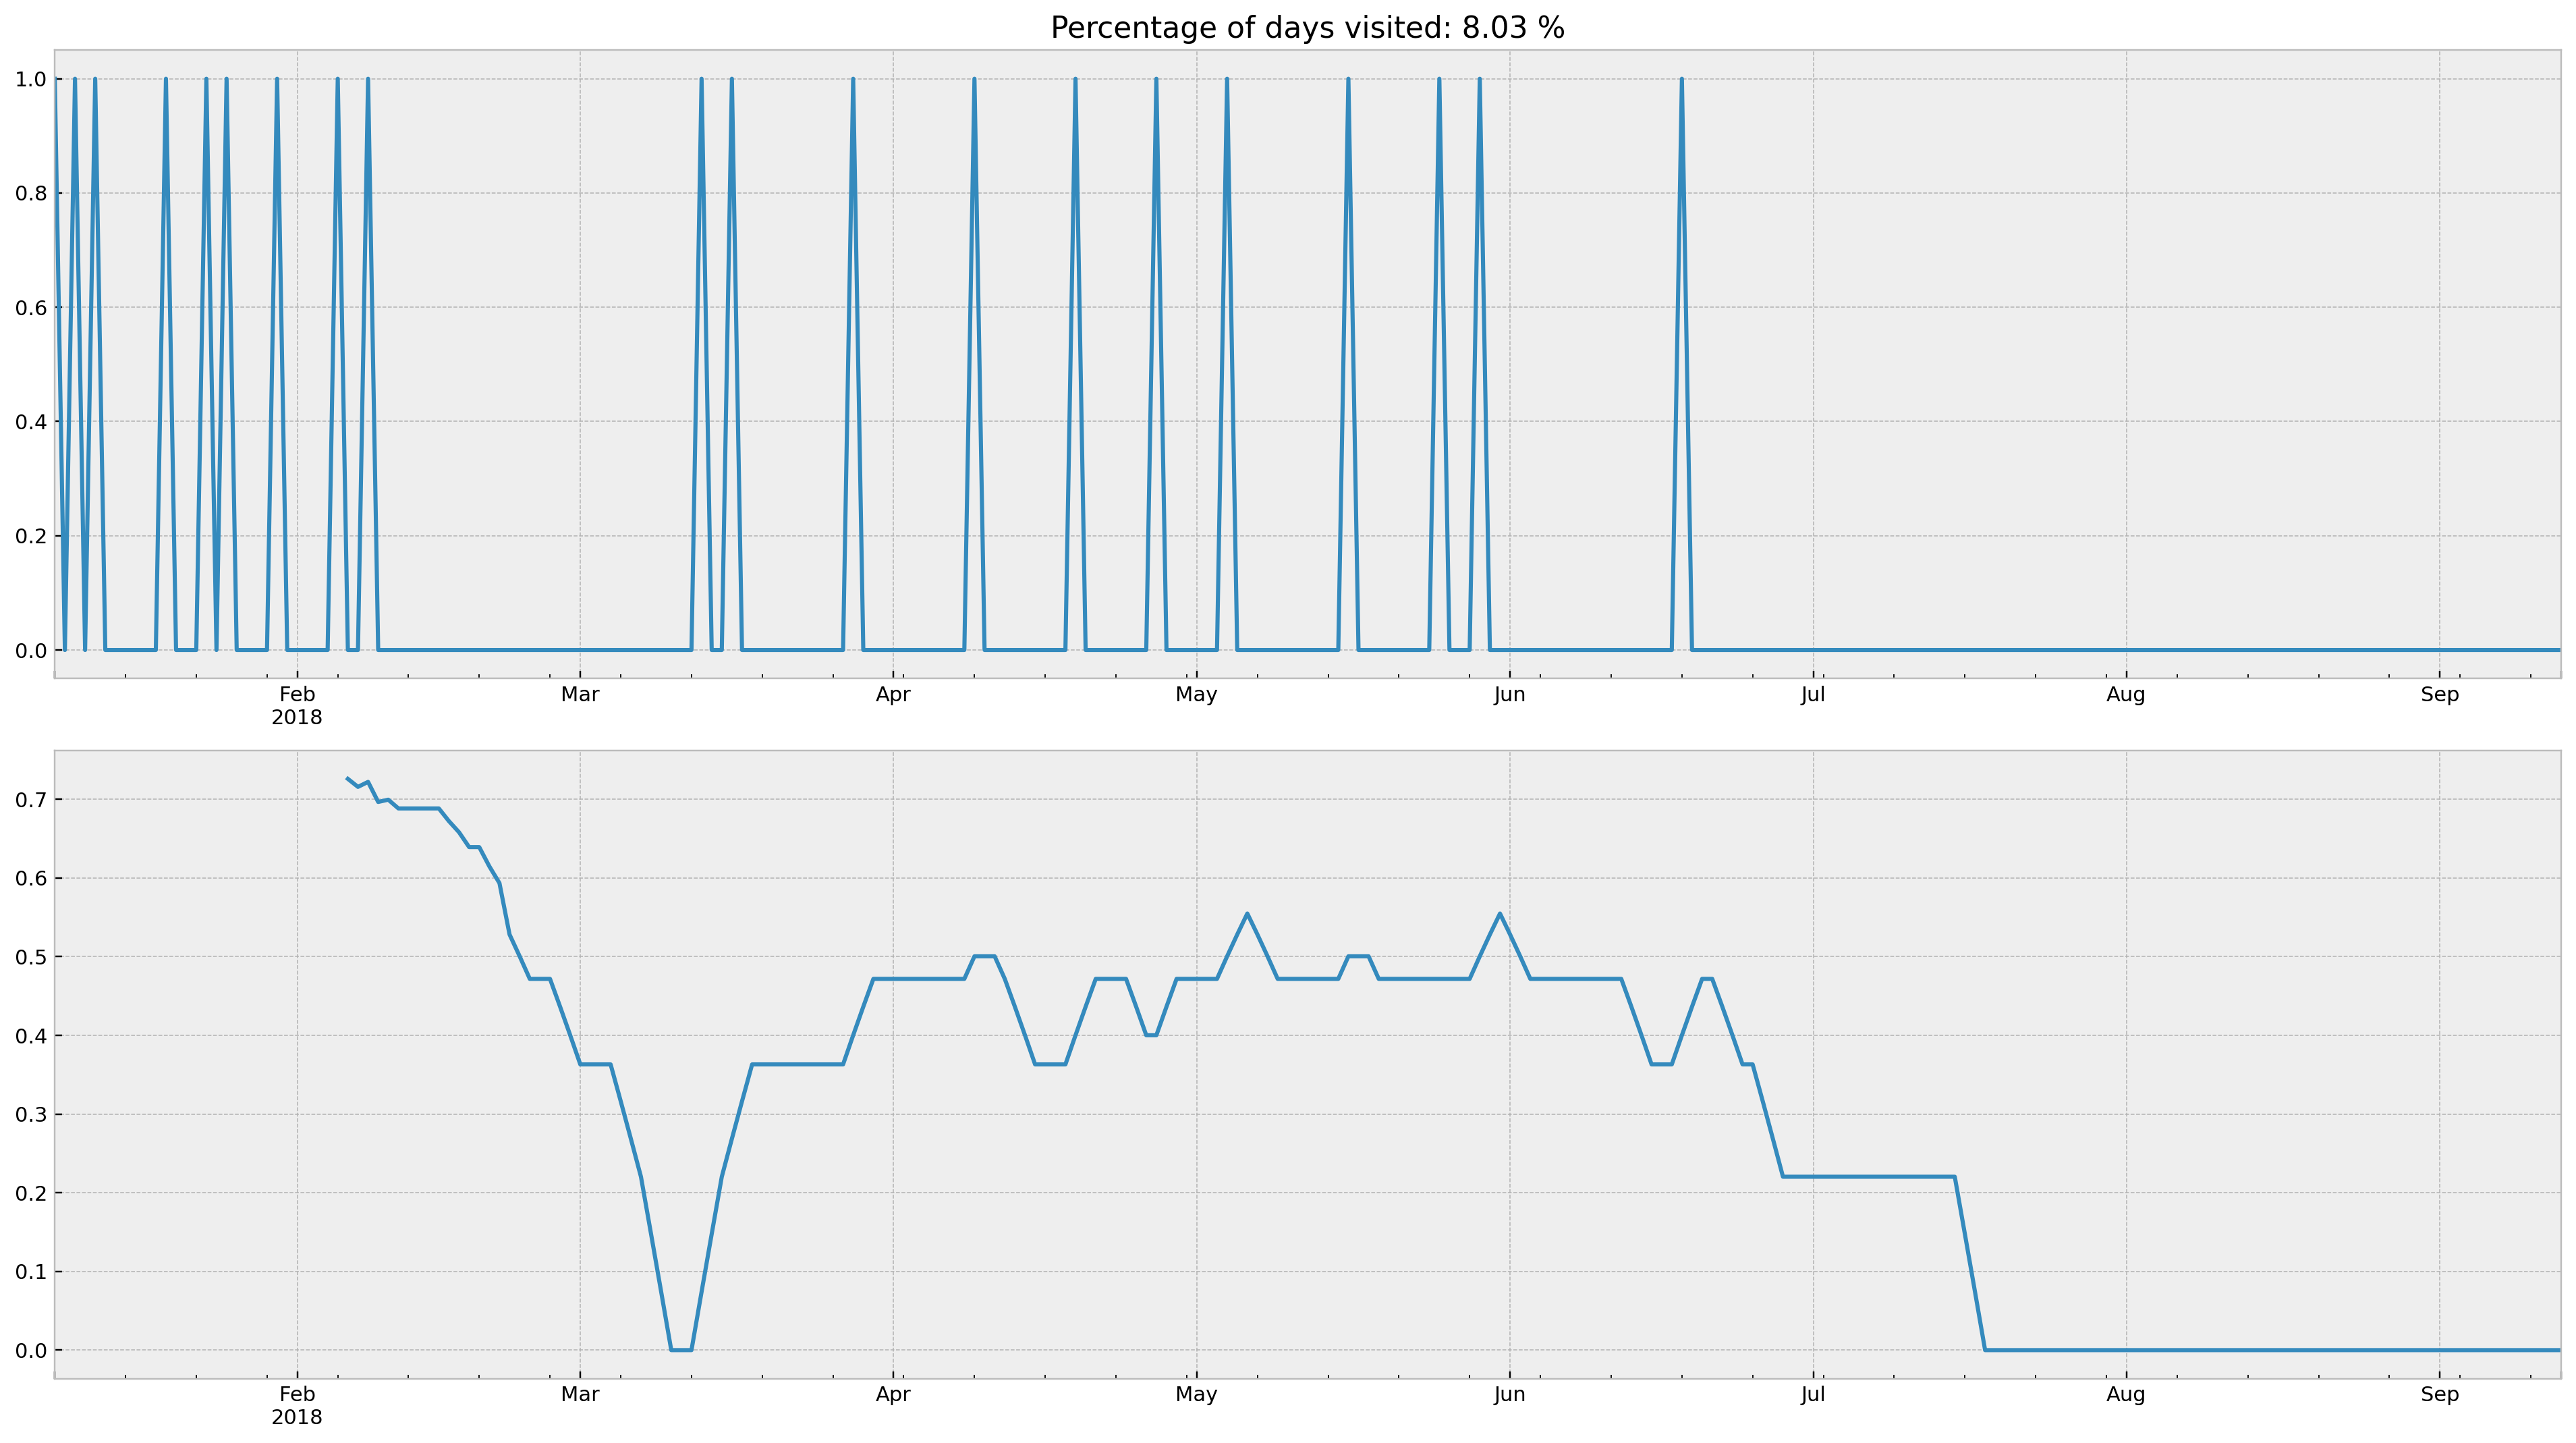

In [242]:
rolling_userplot(sample_code, stat_name="IntRepEn")

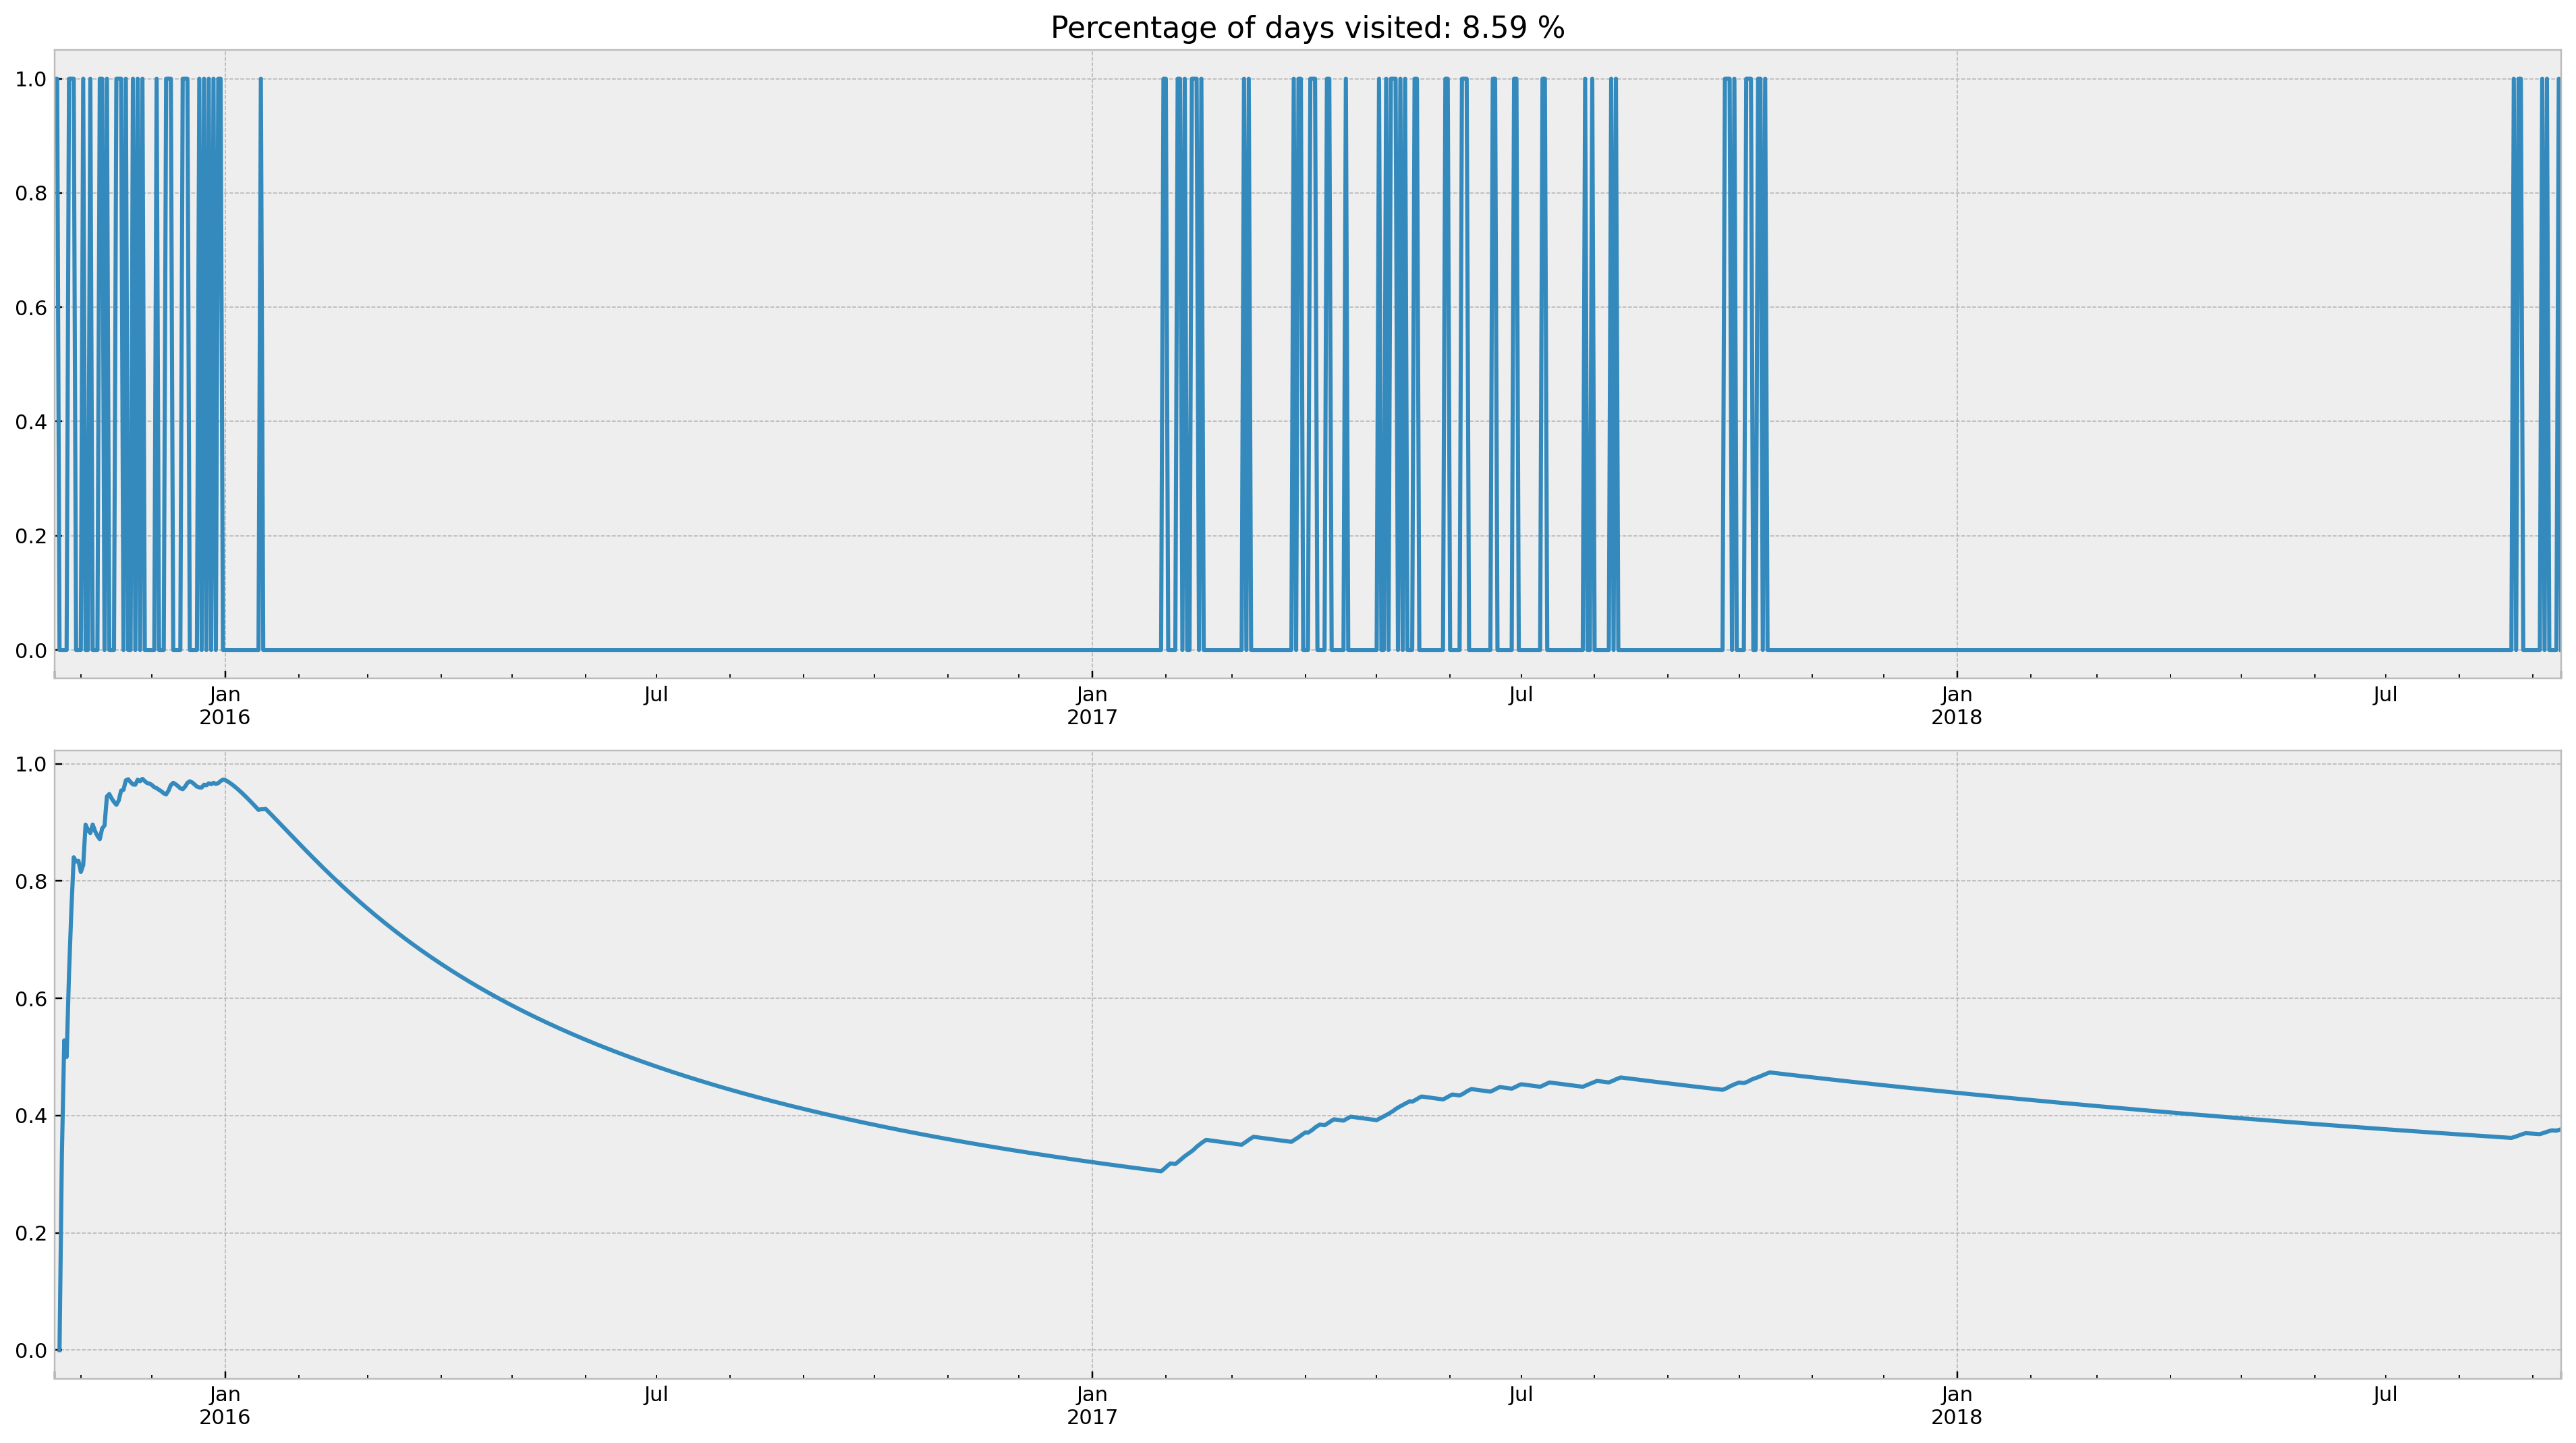

In [217]:
cumulative_userplot(sample_code, stat_name="IntRepEn")

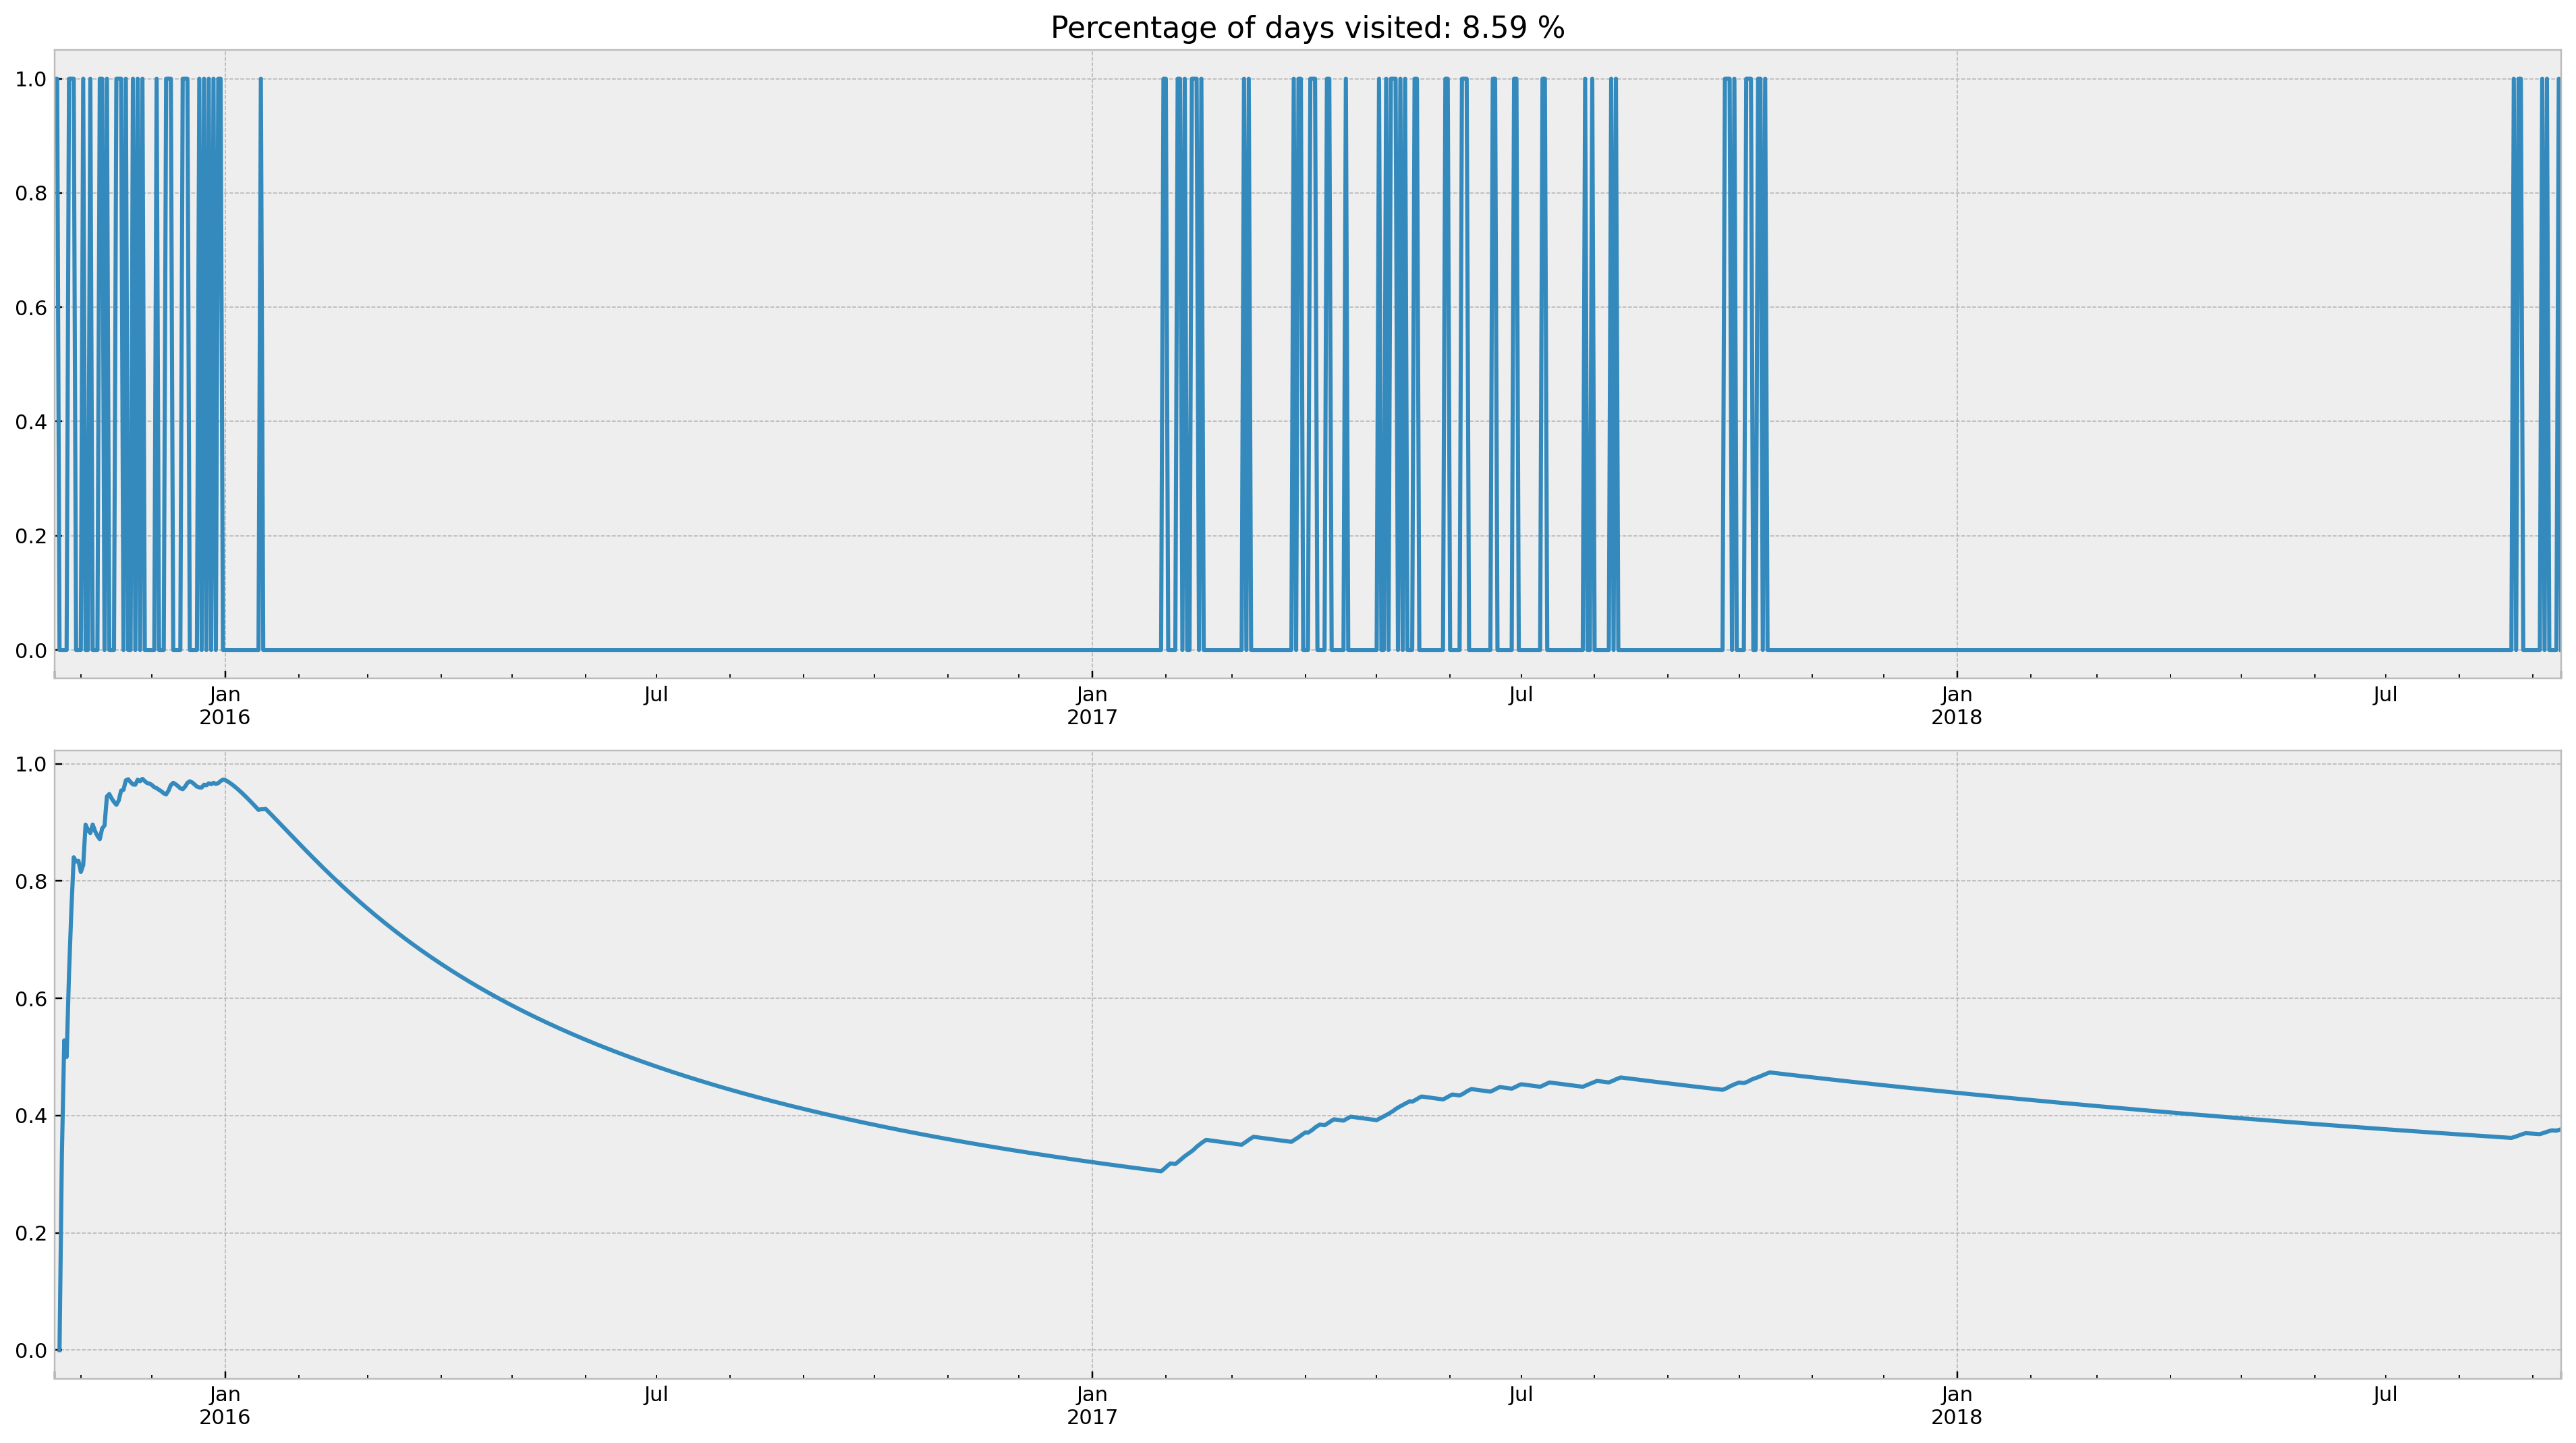

In [215]:
cumulative_userplot(sample_code, stat_name="IntRepEn")